# RankSVM

In [4]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split


In [5]:
def calculate_row_differences(input_array: np.ndarray) -> np.ndarray:
    """Calculate the difference between each row of a 2D array and all other rows.

    Args:
        input_array (np.ndarray): The input 2D array.

    Returns:
        np.ndarray: The resulting array with shape (n, m), where n is the number of rows in input_array
        and m is the number of columns in input_array. Each row of the resulting array is
        the difference between the corresponding row of input_array and all other rows.
    """
    num_rows, num_cols = input_array.shape
    row_strides = input_array.itemsize * num_cols
    
    a_strides = np.lib.stride_tricks.as_strided(
        input_array,
        (num_rows, num_rows, num_cols),
        (row_strides, 0, input_array.itemsize),
    )
    a_reshaped = a_strides.reshape(-1, num_cols)
    
    b_strides = np.lib.stride_tricks.as_strided(
        input_array,
        (num_rows, num_rows, num_cols),
        (0, row_strides, input_array.itemsize),
    )
    b_reshaped = b_strides.reshape(-1, num_cols)
    
    return a_reshaped - b_reshaped

def load_data(path: str, target_map: dict, num_criteria: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocesses the data for training a machine learning model.

    Args:
        path (str): The path to the CSV file containing the data.
        target_map (dict): A dictionary mapping target values to binary labels.
        num_criteria (int): The number of criteria used for classification.

    Returns:
        tuple: A tuple containing the preprocessed data and the train-test split.
    """
    # Read the data from the CSV file
    data = pd.read_csv(path, header=None)

    # Apply the target mapping to convert target values to binary labels
    data[num_criteria] = data[num_criteria].apply(lambda x: target_map[x])

    # Remove duplicate rows from the data
    data = data.drop_duplicates()

    # Split the data into input features and target variable
    data_input = data.iloc[:, :num_criteria].values
    data_target = data[num_criteria].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_target, test_size=0.2, random_state=1234
    )

    return (X_train, X_test, y_train, y_test)


In [6]:
# Load the data and preprocess it
path = "MonoData/breast_cancer.csv"
target_map = {1: 0, 2: 1}
num_criteria = 7
X_train, X_test, y_train, y_test = load_data(path, target_map, num_criteria)

# Calculate the differences between each row of the input features
X_train = calculate_row_differences(X_train)
X_test = calculate_row_differences(X_test)
y_train = calculate_row_differences(y_train.reshape(-1, 1))[:, 0]
y_test = calculate_row_differences(y_test.reshape(-1, 1))[:, 0]

# Take only the rows where the target variable is not 0, so they are in the diffrent class
X_train = X_train[y_train != 0]
y_train = y_train[y_train != 0]

X_test = X_test[y_test != 0]
y_test = y_test[y_test != 0]


In [7]:
# Create a linear SVM model
model = svm.LinearSVC()

# Fit the model to the training data
_ = model.fit(X_train,y_train)

c:\Users\maciej\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [8]:
y_pred_train = model.predict(X_train)
out_train = np.dot(X_train, model.coef_.T)
accuracy_train = accuracy_score(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, out_train) 
print(f"Accuracy train:\t{accuracy_train:.2%}")
print(f"AUC train: \t{auc_train:.2%}\n")

y_pred_test = model.predict(X_test)
out_test = np.dot(X_test, model.coef_.T)
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, out_test) 
print(f"Accuracy test:\t{accuracy_test:.2%}")
print(f"AUC test: \t{auc_test:.2%}")


Accuracy train:	71.79%
AUC train: 	78.85%

Accuracy test:	84.42%
AUC test: 	93.77%


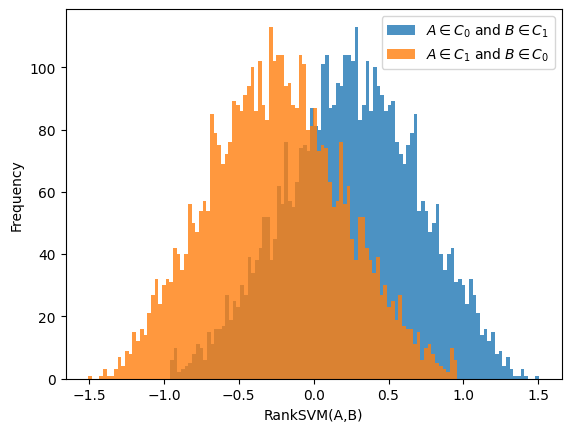

In [9]:
# Class distribution of training data
plt.hist(out_train[y_train==1], alpha=0.8, bins=100, label='$A \in C_0$ and $B \in C_1$') # A in C0 and B in C1 so score should be positive
plt.hist(out_train[y_train==-1], alpha=0.8, bins=100, label='$A \in C_1$ and $B \in C_0$') # A in C1 and B in C0 so score should be negative
plt.xlabel("RankSVM(A,B)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

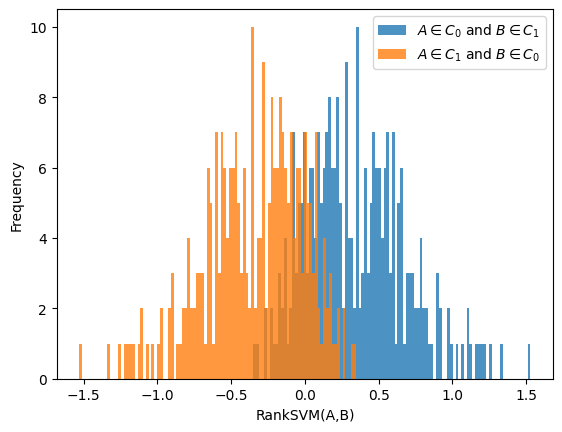

In [10]:
# Class distribution of test data
plt.hist(out_test[y_test==1], alpha=0.8, bins=100, label='$A \in C_0$ and $B \in C_1$') # A in C0 and B in C1 so score should be positive
plt.hist(out_test[y_test==-1], alpha=0.8, bins=100, label='$A \in C_1$ and $B \in C_0$') # A in C1 and B in C0 so score should be negative
plt.xlabel("RankSVM(A,B)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [11]:
# Model coefficients
w = model.coef_[0]
print(f'Criteria coefficients {w}')
b = model.intercept_[0]
print(f'Intercept {b}')

Criteria coefficients [ 0.16429538  0.56326959  0.30531916  0.04381764  0.59506625 -0.05369083
  0.06819459]
Intercept 1.214148347927508e-06


In [12]:
def plot_density(X_train: np.ndarray, y_train: np.ndarray, criterion_1: int, criterion_2: int, samples: int = 10000) -> None:
    """Plot the density of the training data and the decision boundary. Plots only pairs of criteria criterion_1 and criterion_2. 

    Args:
        X_train (np.ndarray): Input features of the training data.
        y_train (np.ndarray): Target variable of the training data.
        criterion_1 (int): The index of the first criterion.
        criterion_2 (int): The index of the second criterion.
        samples (int, optional): The number of samples to plot. Defaults to 10000.

    """
    # Plot the density of the training data
    axes = sns.jointplot(
        x=X_train[:samples, criterion_1],
        y=X_train[:samples, criterion_2],
        hue=y_train[:samples],
        kind="kde",
        palette=["green", "red"],
        fill=True,
        alpha=0.5,
    )
    
    # Plot the decision boundary
    x_points = np.linspace(-1, 1)
    y_points = -(w[criterion_1] / w[criterion_2]) * x_points - b / w[criterion_2]
    x_points = x_points[np.logical_and(y_points < 1, y_points > -1)]
    y_points = y_points[np.logical_and(y_points < 1, y_points > -1)]
    axes.ax_joint.plot(x_points, y_points, c="blue")
    
    # Set labels for axes
    axes.ax_joint.set_xlabel(f"Criterion: {criterion_1}")
    axes.ax_joint.set_ylabel(f"Criterion: {criterion_2}")


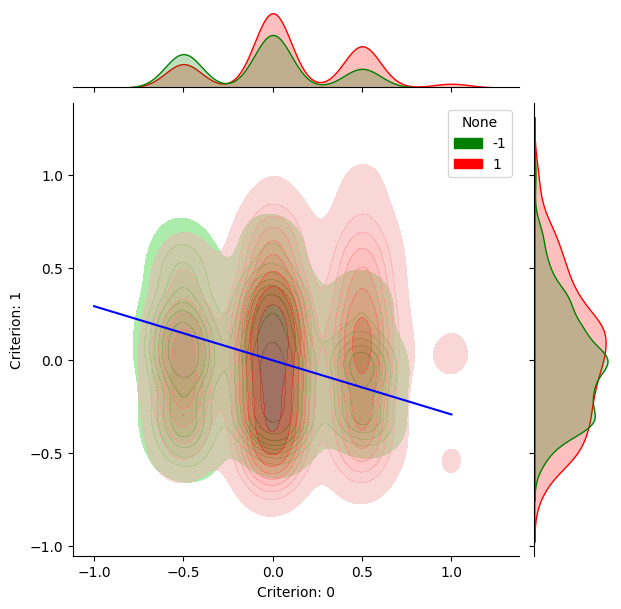

In [13]:
c_1 = 0
c_2 = 1
plot_density(X_train, y_train, c_1, c_2, samples=1000)


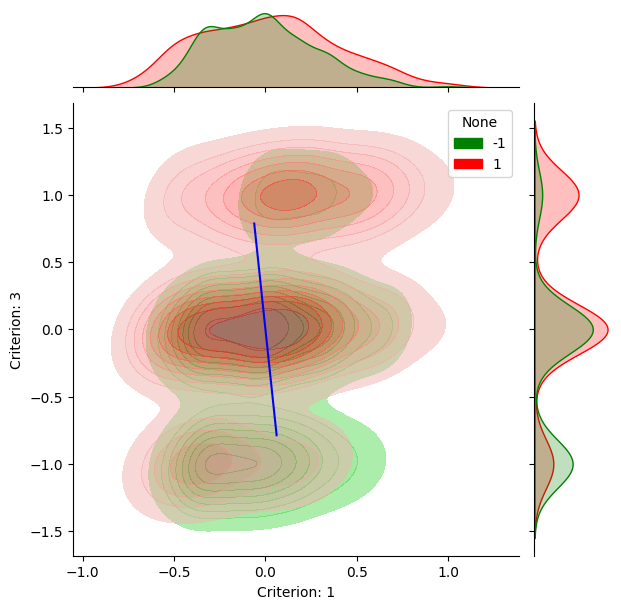

In [14]:
c_1 = 1
c_2 = 3
plot_density(X_train, y_train, c_1, c_2, samples=1000)